In [1]:
import spatialproteomics as sp
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d
import pandas as pd
import xarray as xr
import numpy as np
from PIL import Image

In [2]:
ds_cellpose_2_4_arcsinh = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_arcsinh.zarr")
ds_cellpose_2_4_clip = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_clip.zarr")
ds_cellpose_2_4_double_zscore = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_double_zscore.zarr")
ds_cellpose_2_4_minmax = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_minmax.zarr")
ds_cellpose_2_4_zscore = xr.open_zarr("/dss/dsshome1/00/ge65tib2/Spatialproteomics/Data_zarr/ds_cellpose_2_4_zscore.zarr")


# quick plotting of some channels
#plt.figure(figsize=(10, 10))
#stardist_arcsinh_2_4.pp[['PD-1', 'CD8', 'PDL1']].pl.autocrop().pl.show()



In [3]:
ds_cellpose_2_4_arcsinh

<xarray.Dataset> Size: 280MB
Dimensions:        (channels: 40, y: 2501, x: 2644, cells: 6888, features: 2)
Coordinates:
  * cells          (cells) int64 55kB 1 2 3 4 5 6 ... 6884 6885 6886 6887 6888
  * channels       (channels) <U15 2kB 'DAPI' 'SOX2' 'FAP' ... 'MCT4' 'LAG3'
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
  * x              (x) int64 21kB 0 1 2 3 4 5 ... 2638 2639 2640 2641 2642 2643
  * y              (y) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499 2500
Data variables:
    _image         (channels, y, x) uint8 265MB dask.array<chunksize=(5, 626, 661), meta=np.ndarray>
    _intensity     (cells, channels) float64 2MB dask.array<chunksize=(1722, 20), meta=np.ndarray>
    _obs           (cells, features) float64 110kB dask.array<chunksize=(6888, 2), meta=np.ndarray>
    _segmentation  (y, x) uint16 13MB dask.array<chunksize=(626, 661), meta=np.ndarray>

In [4]:
print(ds_cellpose_2_4_arcsinh['channels']) 

<xarray.DataArray 'channels' (channels: 40)> Size: 2kB
array(['DAPI', 'SOX2', 'FAP', 'cxcr3', 'LRRC15', 'CD20', 'CD68', 'CD45RO',
       'CD31', 'PD-1', 'Ki67', 'Keratin 5', 'CD4', 'IFNG', 'SMA', 'CD66',
       'Podoplanin', 'CXCR4', 'PGRN', 'Granzyme B', 'Pan-Cytokeratin', 'MARCO',
       'CD56', 'HAS1', 'CD107a', 'b-Catenin1', 'HLA-A', 'HLA-DR', 'CD8',
       'PDL1', 'TP63', 'GATA6', 'CD34', 'TCF-1', 'Bcl-2', 'PCNA', 'CLDN18',
       'CD3e', 'MCT4', 'LAG3'], dtype='<U15')
Coordinates:
  * channels  (channels) <U15 2kB 'DAPI' 'SOX2' 'FAP' ... 'CD3e' 'MCT4' 'LAG3'


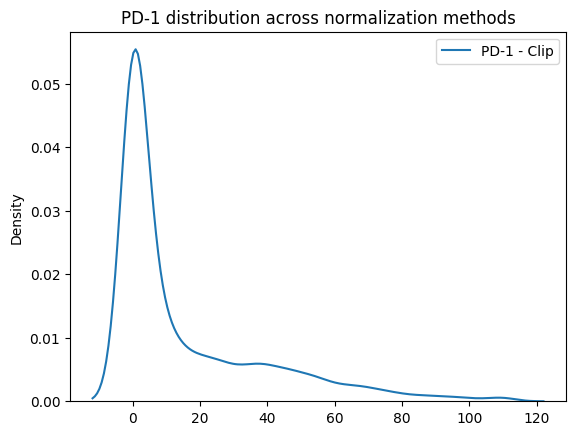

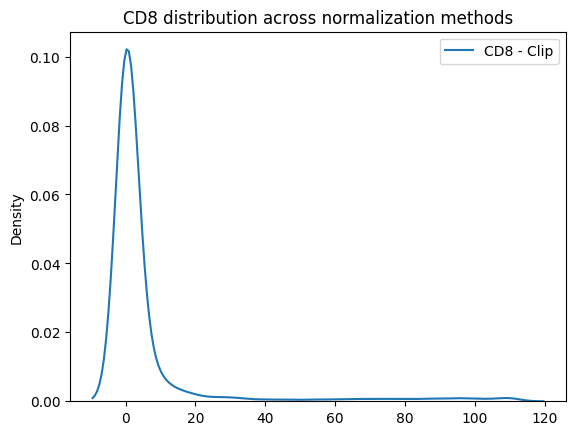

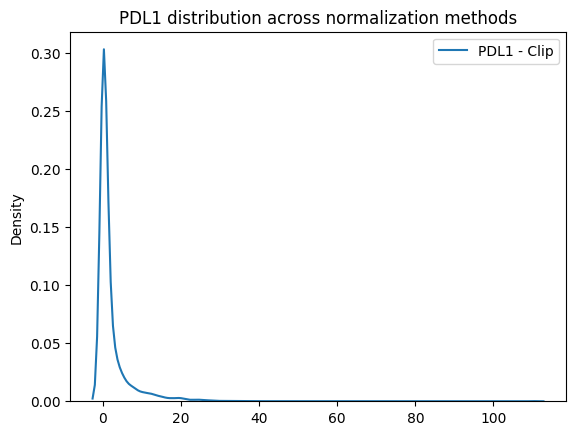

In [8]:
import seaborn as sns

for marker in ['PD-1', 'CD8', 'PDL1']:  # Make sure these names match exactly what's in your channels
    
    # Plot each normalization method
    #plt.figure(figsize=(10, 6))
    
    # Zscore
    #sns.kdeplot(ds_cellpose_2_4_zscore['_intensity'].sel(channels=marker).values.flatten(), label=f'{marker} - zscore')
    
    # Double Zscore
    #sns.kdeplot(ds_cellpose_2_4_double_zscore['_intensity'].sel(channels=marker).values.flatten(), label=f'{marker} - double_zscore')
    
    # MinMax
    #sns.kdeplot(ds_cellpose_2_4_minmax['_intensity'].sel(channels=marker).values.flatten(), label=f'{marker} - MinMax')
    
    # ArcSin
    #sns.kdeplot(ds_cellpose_2_4_arcsinh['_intensity'].sel(channels=marker).values.flatten(), label=f'{marker} - ArcSin')
    
    # Clip
    sns.kdeplot(ds_cellpose_2_4_clip['_intensity'].sel(channels=marker).values.flatten(), label=f'{marker} - Clip')

    plt.title(f'{marker} distribution across normalization methods')
    plt.legend()
    plt.show()

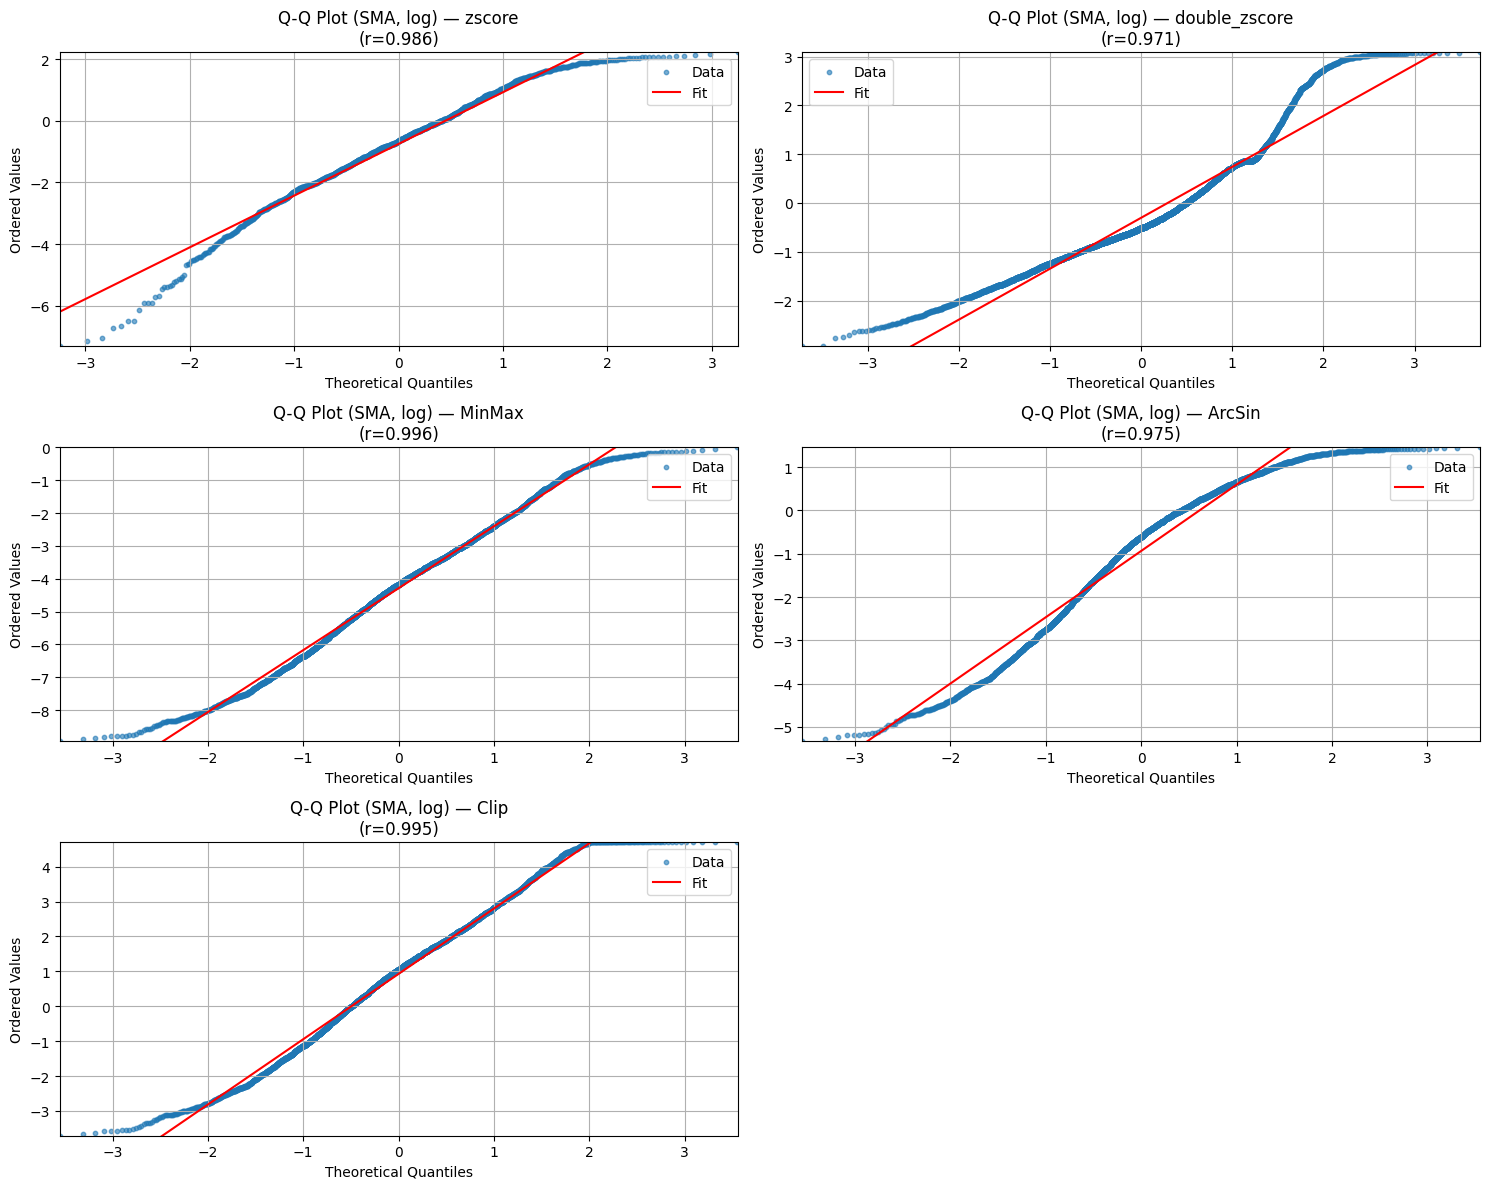

In [9]:
from scipy import stats

#### QQ-Plot ####
dfs = [ds_cellpose_2_4_zscore['_intensity'], ds_cellpose_2_4_double_zscore['_intensity'], ds_cellpose_2_4_minmax['_intensity'], ds_cellpose_2_4_arcsinh['_intensity'],
      ds_cellpose_2_4_clip['_intensity']]
methods = ["zscore", "double_zscore", "MinMax", "ArcSin", "Clip"]

plt.figure(figsize=(15, 12))

for idx, (df, method) in enumerate(zip(dfs, methods), start=1):
    ax = plt.subplot(3, 2, idx)  # Changed to 3 rows to accommodate 5 methods
    
    try:
        # Select SMA channel data and flatten
        data = df.sel(channels='SMA').values.flatten()
        
        # Remove missing and non-positive values
        data = data[~np.isnan(data)]
        data = data[data > 0]
        
        if len(data) == 0:
            print(f"No valid data for SMA in {method}")
            continue
            
        # Log transform
        log_data = np.log(data)
        
        # Generate Q-Q plot
        (theo_q, obs_q), (slope, intercept, r) = stats.probplot(log_data, dist="norm")
        
        # Plot
        ax.scatter(theo_q, obs_q, s=10, alpha=0.6, label='Data')
        ax.plot(theo_q, slope*theo_q + intercept, 'r-', label='Fit')
        
        # Formatting
        ax.set_xlim(theo_q.min(), theo_q.max())
        ax.set_ylim(obs_q.min(), obs_q.max())
        ax.set_title(f"Q-Q Plot (SMA, log) — {method}\n(r={r:.3f})")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Ordered Values")
        ax.legend()
        ax.grid(True)
        
    except KeyError:
        print(f"SMA channel not found in {method} dataset")
        continue

plt.tight_layout()
plt.show()
